In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import nltk
from nltk.corpus import subjectivity
import nltk.sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
stock_prices = pd.read_csv('../input/sensex-history/BSESN.csv')
headlines = pd.read_csv('../input/toi-news-headlines/india-news-headlines.csv')

In [3]:
stock_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0


In [4]:
headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [5]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5326 entries, 0 to 5325
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5326 non-null   object 
 1   Open       5254 non-null   float64
 2   High       5254 non-null   float64
 3   Low        5254 non-null   float64
 4   Close      5254 non-null   float64
 5   Adj Close  5254 non-null   float64
 6   Volume     5254 non-null   float64
dtypes: float64(6), object(1)
memory usage: 291.4+ KB


In [6]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [7]:
# Drop duplicates
stock_prices = stock_prices.drop_duplicates()

# Convert date from string to datetime format 
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.normalize()

# Select important columns
stock_prices = stock_prices.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# Set index column as date and then normalize accoding to index
stock_prices.set_index('Date', inplace= True)
stock_prices = stock_prices.sort_index(ascending=True, axis=0)
stock_prices

,Close,Open,High,Low,Volume
Date,,,,,
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0
...,...,...,...,...,...
2022-04-25,56579.890625,56757.640625,56875.648438,56356.871094,7000.0
2022-04-26,57356.609375,57066.238281,57442.238281,56904.511719,7300.0
2022-04-27,56819.390625,56983.679688,57079.031250,56584.039063,6600.0


In [8]:
# Drop duplicates
headlines = headlines.drop_duplicates()

# Convert dtype of publish date to datetime.date from int64
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()

# Select important columns
headlines = headlines.filter(['publish_date', 'headline_text'])
headlines

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3650965,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [9]:
# Group news headlines by publish_date
headlines = headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# Set publish date as index and sort according to index
headlines.set_index('publish_date', inplace= True)
headlines = headlines.sort_index(ascending=True, axis=0)
headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [10]:
# Concatenating the datasets
stock_data = pd.concat([stock_prices, headlines], axis=1)

# Dropping null values
stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think..."
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...
2022-03-25,57362.199219,57801.718750,57845.371094,57100.238281,6900.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,57593.488281,57472.718750,57638.339844,56825.089844,6300.0,As fashion becomes democratic; demand for styl...
2022-03-29,57943.648438,57814.761719,58001.531250,57639.351563,12100.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,58683.988281,58362.851563,58727.781250,58176.000000,6300.0,"I will not give in to trends: Dossmode,The tim..."


In [11]:
# Downloading vader lexicon
nltk.download('vader_lexicon')

# Cretaing columns for sentiment scores
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...,,,,
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think...",,,,
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...,,,,
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...,,,,
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",,,,


In [12]:
# Calculate sentiment scores

sid = SentimentIntensityAnalyzer()
for i in range(len(stock_data)):
    scores = sid.polarity_scores(str(stock_data.iloc[i,5]))
    stock_data.iloc[i,6] = scores['compound']
    stock_data.iloc[i,7] = scores['neg']
    stock_data.iloc[i,8] = scores['neu']
    stock_data.iloc[i,9] = scores['pos']

stock_data

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-01-02,4018.879883,3953.219971,4028.570068,3929.370117,0.0,Status quo will not be disturbed at Ayodhya; s...,-0.9621,0.119,0.817,0.064
2001-01-03,4060.020020,3977.580078,4067.659912,3977.580078,0.0,"Powerless north India gropes in the dark,Think...",0.6322,0.084,0.817,0.098
2001-01-04,4115.370117,4180.970215,4180.970215,4109.549805,0.0,The string that pulled Stephen Hawking to Indi...,0.6648,0.077,0.843,0.08
2001-01-05,4183.729980,4116.339844,4195.009766,4115.350098,0.0,Light combat craft takes India into club class...,0.9032,0.105,0.746,0.149
2001-01-08,4120.430176,4164.759766,4206.720215,4101.529785,0.0,"Sangh Parivar; Babri panel up the ante,Frontru...",-0.9638,0.119,0.855,0.026
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,57362.199219,57801.718750,57845.371094,57100.238281,6900.0,Speeding up; shortcuts and tackling unruly cus...,-0.9999,0.16,0.776,0.064
2022-03-28,57593.488281,57472.718750,57638.339844,56825.089844,6300.0,As fashion becomes democratic; demand for styl...,-0.9999,0.151,0.763,0.086
2022-03-29,57943.648438,57814.761719,58001.531250,57639.351563,12100.0,Bobby Deol: Like my dad; I hope to be working ...,-0.9998,0.131,0.79,0.079
2022-03-30,58683.988281,58362.851563,58727.781250,58176.000000,6300.0,"I will not give in to trends: Dossmode,The tim...",-0.9999,0.13,0.81,0.061


In [13]:
# Dropping the 'headline_text' as polarity scores are calculated
stock_data.drop(['headline_text'], inplace=True, axis=1)

# Rearranging the columns 
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# Set the index to date
stock_data.index.name = 'Date'
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,4018.879883,-0.9621,0.119,0.817,0.064,3953.219971,4028.570068,3929.370117,0.0
2001-01-03,4060.020020,0.6322,0.084,0.817,0.098,3977.580078,4067.659912,3977.580078,0.0
2001-01-04,4115.370117,0.6648,0.077,0.843,0.08,4180.970215,4180.970215,4109.549805,0.0
2001-01-05,4183.729980,0.9032,0.105,0.746,0.149,4116.339844,4195.009766,4115.350098,0.0
2001-01-08,4120.430176,-0.9638,0.119,0.855,0.026,4164.759766,4206.720215,4101.529785,0.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,57362.199219,-0.9999,0.16,0.776,0.064,57801.718750,57845.371094,57100.238281,6900.0
2022-03-28,57593.488281,-0.9999,0.151,0.763,0.086,57472.718750,57638.339844,56825.089844,6300.0
2022-03-29,57943.648438,-0.9998,0.131,0.79,0.079,57814.761719,58001.531250,57639.351563,12100.0


In [14]:
# Saving preprocessed data
stock_data.to_csv('stock_data.csv')

In [15]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5206 entries, 2001-01-02 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     5206 non-null   float64
 1   compound  5206 non-null   object 
 2   negative  5206 non-null   object 
 3   neutral   5206 non-null   object 
 4   positive  5206 non-null   object 
 5   Open      5206 non-null   float64
 6   High      5206 non-null   float64
 7   Low       5206 non-null   float64
 8   Volume    5206 non-null   float64
dtypes: float64(5), object(4)
memory usage: 406.7+ KB


Text(0, 0.5, 'Close Price ($)')

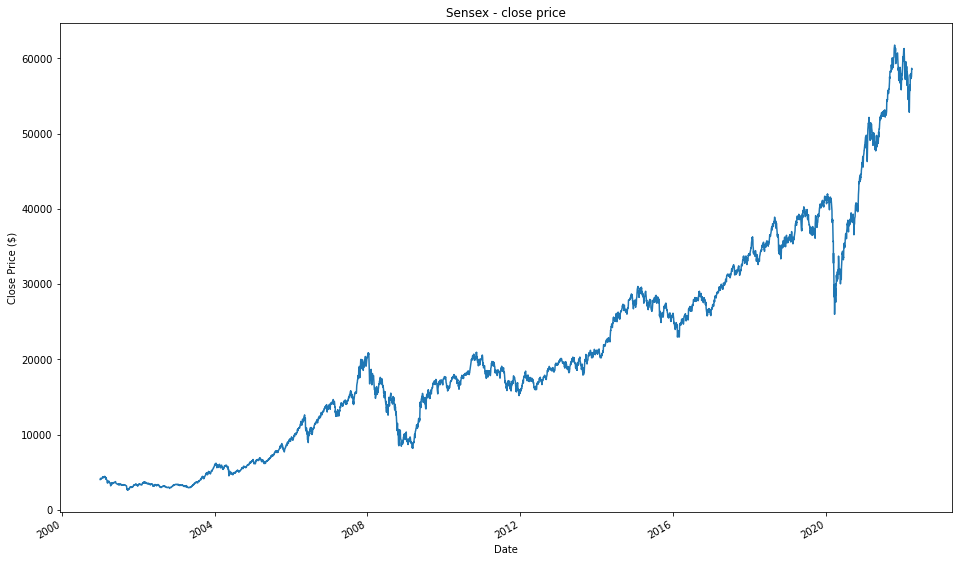

In [16]:
# setting figure size
plt.figure(figsize=(16,10))

# plotting close price
stock_data['Close'].plot()

# setting plot title, x and y labels
plt.title("Sensex - close price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [17]:
# Calculate 7 day rolling mean (i.e. 7 day moving average)
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,4095.911447,-0.179071,0.121714,0.810429,0.067571,4094.170027,4143.089983,4052.832799,0.0
2001-01-23,4135.598598,0.091157,0.109857,0.818571,0.071286,4140.542899,4184.972831,4101.904227,0.0
2001-01-24,4173.655727,-0.128286,0.111571,0.825286,0.063000,4189.532854,4223.794294,4147.351353,0.0


In [18]:
# Create output column shifted_close using closing prices

close_price = stock_data.loc[:, 'Close']
stock_data['shifted_close'] = close_price.shift(-1)    # Closing price for next day is prediction for current day

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
# Keep only the compound sentiment score in the input data

cols_to_drop = ['negative', 'neutral', 'positive']
stock_data.drop(cols_to_drop, axis=1, inplace=True)

# Drop null columns
stock_data.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [20]:
Y = stock_data.loc[:,'shifted_close']
stock_data.drop(['shifted_close'], axis=1, inplace=True)

In [21]:
# Scaling data
scaler_x = MinMaxScaler(feature_range=(-1, 1))
x = np.array(stock_data).reshape((len(stock_data) ,len(stock_data.columns)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y = np.array(Y).reshape ((len(Y), 1))
y = scaler_y.fit_transform (y)

x, y

(array([[-0.95204095, -0.9621    , -0.95527541, -0.95480471, -0.95478553,
         -1.        ],
        [-0.95065027,  0.6322    , -0.95445706, -0.95349215, -0.95315212,
         -1.        ],
        [-0.94877925,  0.6648    , -0.94762439, -0.94968742, -0.94868083,
         -1.        ],
        ...,
        [ 0.85896836, -0.9999    ,  0.8426541 ,  0.84530322,  0.83738517,
         -0.99960396],
        [ 0.870805  , -0.9998    ,  0.85414467,  0.85749845,  0.86497334,
         -0.99923935],
        [ 0.89583108, -0.9999    ,  0.87255715,  0.88188446,  0.88315564,
         -0.99960396]]),
 array([[-0.95065027],
        [-0.94877925],
        [-0.94646844],
        ...,
        [ 0.870805  ],
        [ 0.89583108],
        [ 0.89192757]]))

In [22]:
data_size = len(stock_data)
train_size = 0.8
train_index = int(train_size*data_size)
X_train = x[:train_index, :]
X_test = x[train_index: , :]    
y_train = y[0 : train_index] 
y_test = y[train_index:] 

print(X_train.shape)
print(y_train.shape)

(4164, 6)
(4164, 1)


In [23]:
# Reshape the dataset for the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (4164, 6, 1)
Shape of Test set X: (1041, 6, 1)


In [24]:
# Create the model
model=keras.models.Sequential()
model.add(keras.layers.LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(stock_data.columns),1)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(100,return_sequences=True,activation='tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(100,activation='tanh'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1))

model.summary()

2022-05-18 17:37:23.684167: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 6, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [25]:
# compile and fit the model
model.compile(loss='mse' , optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

2022-05-18 17:37:24.657400: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
417/417 [==============================] - 15s 23ms/step - loss: 0.0231 - val_loss: 0.0412
Epoch 2/10
417/417 [==============================] - 8s 19ms/step - loss: 0.0037 - val_loss: 0.0117
Epoch 3/10
417/417 [==============================] - 8s 19ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/10
417/417 [==============================] - 8s 19ms/step - loss: 0.0014 - val_loss: 1.7310e-04
Epoch 5/10
417/417 [==============================] - 8s 19ms/step - loss: 0.0012 - val_loss: 1.2287e-04
Epoch 6/10
417/417 [==============================] - 8s 20ms/step - loss: 0.0012 - val_loss: 5.5363e-04
Epoch 7/10
417/417 [==============================] - 8s 19ms/step - loss: 0.0013 - val_loss: 2.7811e-04
Epoch 8/10
417/417 [==============================] - 8s 19ms/step - loss: 9.7214e-04 - val_loss: 0.0014
Epoch 9/10
417/417 [==============================] - 8s 19ms/step - loss: 9.3169e-04 - val_loss: 2.2029e-04
Epoch 10/10
417/417 [==============================] - 9s 21ms

In [26]:
predictions = model.predict(X_test) 

predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))
print('Predictions:')
predictions[0:5]

rmse = metrics.mean_squared_error(y_test, predictions)
print('RMSE =',np.sqrt(rmse))

Predictions:
RMSE = 41795.08981079004


In [27]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(stock_data.columns))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

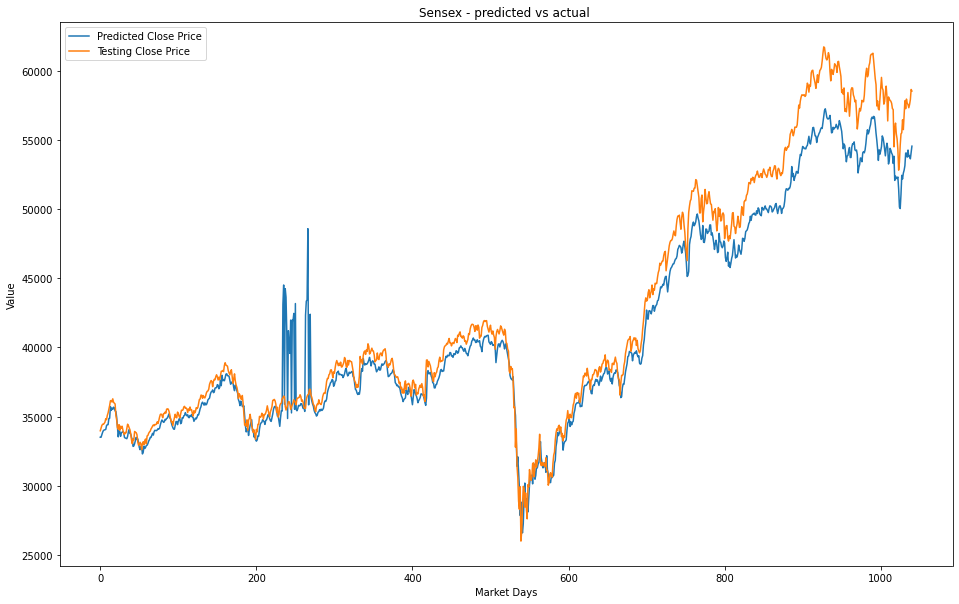

In [28]:

plt.figure(figsize=(16,10))
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.title('Sensex - predicted vs actual ')
plt.xlabel('Market Days')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()